# Machine Learning with DatMesh

Training data set is synthetic bank transaction data: https://www.kaggle.com/ntnu-testimon/paysim1/data

Notebook: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services

## Install Python packages

In [1]:
!python3 -m pip install --user pandas seaborn sklearn pyarrow
import sys
sys.path.append('/home/jovyan/.local/lib/python3.6/site-packages')

     |████████████████████████████████| 10.5MB 8.4MB/s eta 0:00:01            | 1.5MB 463kB/s eta 0:00:20     |███████████▋                    | 3.8MB 463kB/s eta 0:00:15��██▍                 | 4.7MB 463kB/s eta 0:00:13               | 5.4MB 463kB/s eta 0:00:11��██████████████████████▊        | 7.8MB 463kB/s eta 0:00:06
     |████████████████████████████████| 286kB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 17.5MB 10.4MB/s eta 0:00:01                 | 2.3MB 13.5MB/s eta 0:00:02                    | 3.0MB 13.5MB/s eta 0:00:02     |██████████                      | 5.5MB 13.5MB/s eta 0:00:01███▋                  | 7.4MB 13.5MB/s eta 0:00:01�███████████▎                 | 7.8MB 13.5MB/s eta 0:00:01     |██████████████████              | 9.9MB 3.2MB/s eta 0:00:03     |██████████████████████          | 12.0MB 3.2MB/s eta 0:00:02     |███████████████████████         | 12.5MB 3.2MB/s eta 0:00:02██████▊       | 13.5MB 10.4MB/s eta 0:00:01
     |███████████████████████████████

## Import ML dependencies

In [2]:
import sys
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

## Get Data

### Load Data from DatMesh

In [3]:
import pyarrow.flight as fl
import json
client = fl.connect("grpc://r02a1f35604f686544374-arrow-flight-module.m4d-system.svc.cluster.local:80")
request = {
    "asset": "m4d-objectstorage-secret-provider-test/transactions.csv", 
    "columns": ["step", "type", "amount", "nameOrig", "oldbalanceOrg", "newbalanceOrig", "nameDest", "oldbalanceDest", "newbalanceDest", "isFraud", "isFlaggedFraud"]
}
info: fl.FlightInfo = client.get_flight_info(
        fl.FlightDescriptor.for_command(json.dumps(request)))
    
result = client.do_get(info.endpoints[0].ticket)

df: pd.DataFrame = result.read_pandas()

df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,XXXXX,170136.00,160296.36,XXXXX,0.00,0.00,0,0
1,1,PAYMENT,1864.28,XXXXX,21249.00,19384.72,XXXXX,0.00,0.00,0,0
2,1,TRANSFER,181.00,XXXXX,181.00,0.00,XXXXX,0.00,0.00,1,0
3,1,CASH_OUT,181.00,XXXXX,181.00,0.00,XXXXX,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,XXXXX,41554.00,29885.86,XXXXX,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,XXXXX,339682.13,0.00,XXXXX,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,XXXXX,6311409.28,0.00,XXXXX,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,XXXXX,6311409.28,0.00,XXXXX,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,XXXXX,850002.52,0.00,XXXXX,0.00,0.00,1,0


### Read Data

In [4]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                     'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

print(df.head())

# Check for missing values in DataFrame
df.isnull().values.any()

   step      type    amount nameOrig  oldBalanceOrig  newBalanceOrig nameDest  \
0     1   PAYMENT   9839.64    XXXXX        170136.0       160296.36    XXXXX   
1     1   PAYMENT   1864.28    XXXXX         21249.0        19384.72    XXXXX   
2     1  TRANSFER    181.00    XXXXX           181.0            0.00    XXXXX   
3     1  CASH_OUT    181.00    XXXXX           181.0            0.00    XXXXX   
4     1   PAYMENT  11668.14    XXXXX         41554.0        29885.86    XXXXX   

   oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0             0.0             0.0        0               0  
1             0.0             0.0        0               0  
2             0.0             0.0        1               0  
3         21182.0             0.0        1               0  
4             0.0             0.0        0               0  


False

## Exploratory Data Analysis

### Determine types of transactions that are fraudulent

In [5]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116



 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


### Determine when isFlaggedFraud gets set 

In [6]:

print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 9

print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) # 4158

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))



The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64

The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158

Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874.0, 19585040.0]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668.0]


#### Conclusion: 
Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

## Data Cleaning
From the exploratory data analysis, we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

In [7]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA and columns with redacted data
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

### Imputation of Latent Missing Values

In [8]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

#Since the destination account balances being zero is a strong indicator of fraud, we replace the value of 0 with -1
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


## Feature Engineering
Create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [9]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

## Data Visualization
Visualize the differences between fraudulent and genuine transactions to confirm that an ML algorithm can make strong predictions

In [10]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

### Dispersion Over Time 
This plot shows how the fraudulent and genuine transactions yield different figerprints when their dispersion is views over time

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


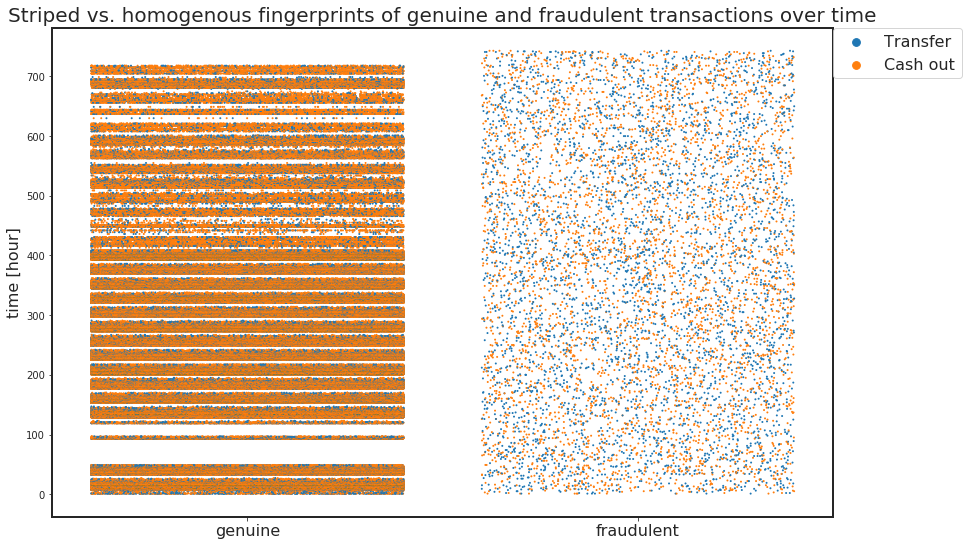

In [11]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

### Dispersion Over Amount
The new `errorBalanceDest` feature is more effective at making a distinction than the original `amount` feature

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


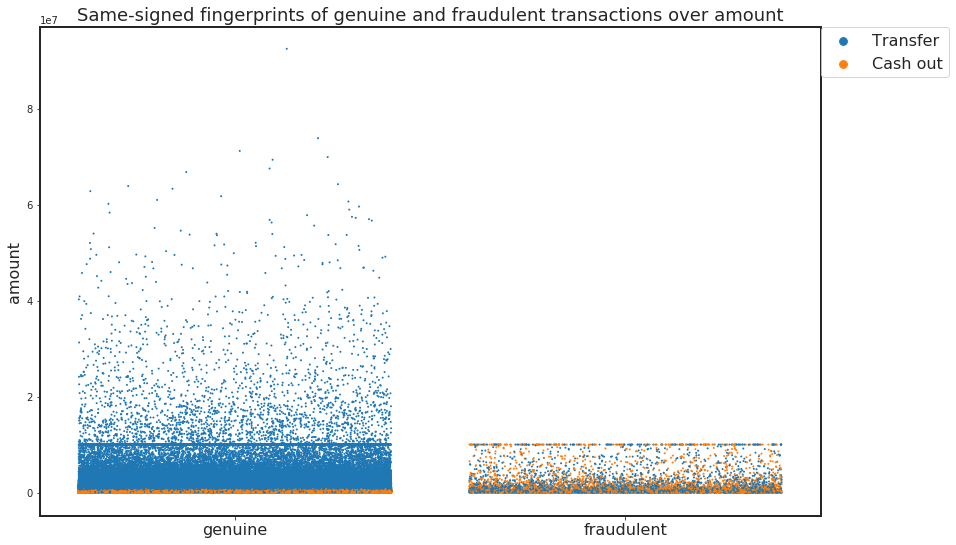

In [12]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

### Dispersion Over Error in Balance in Destination Accounts

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


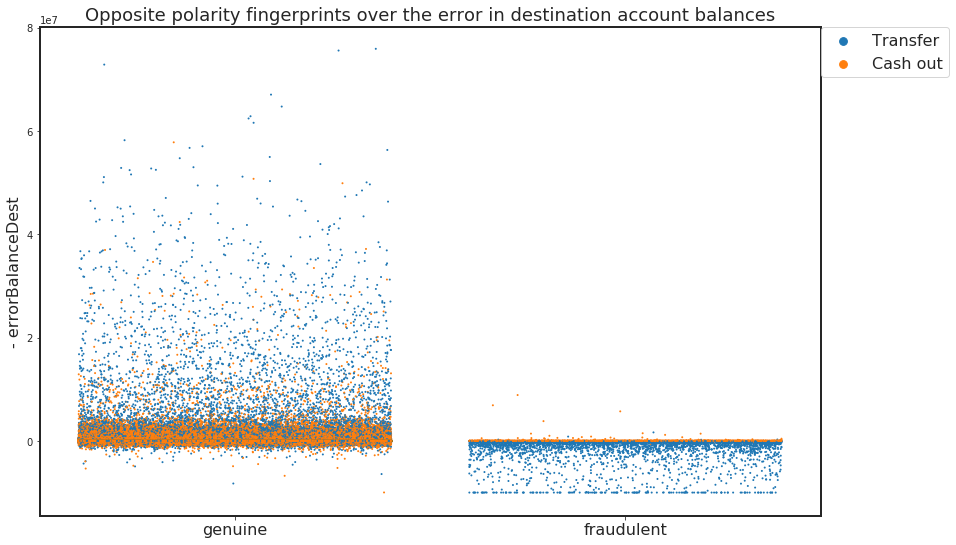

In [13]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

### Separating Out Genuine From Fraudulent Transactions
The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. 

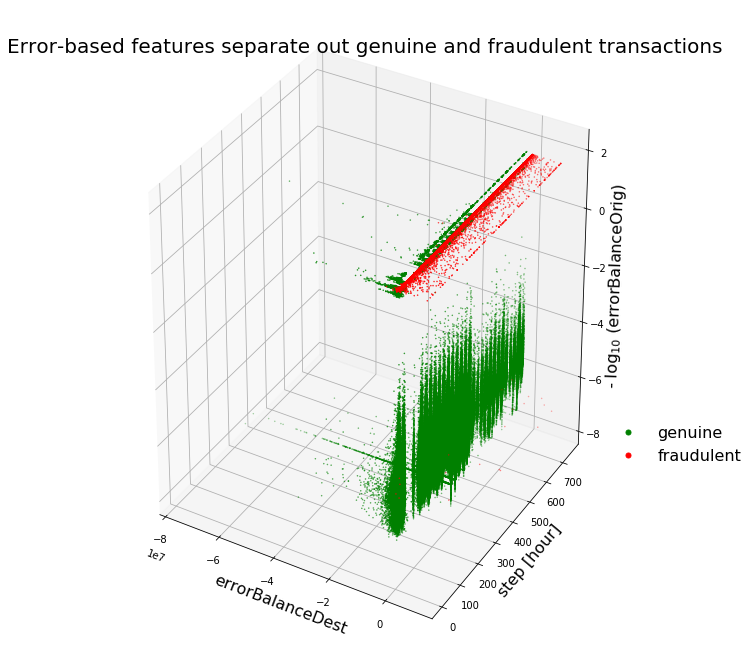

In [14]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

### Fingerprints of Genuine and Fraudulent Transactions
Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below.

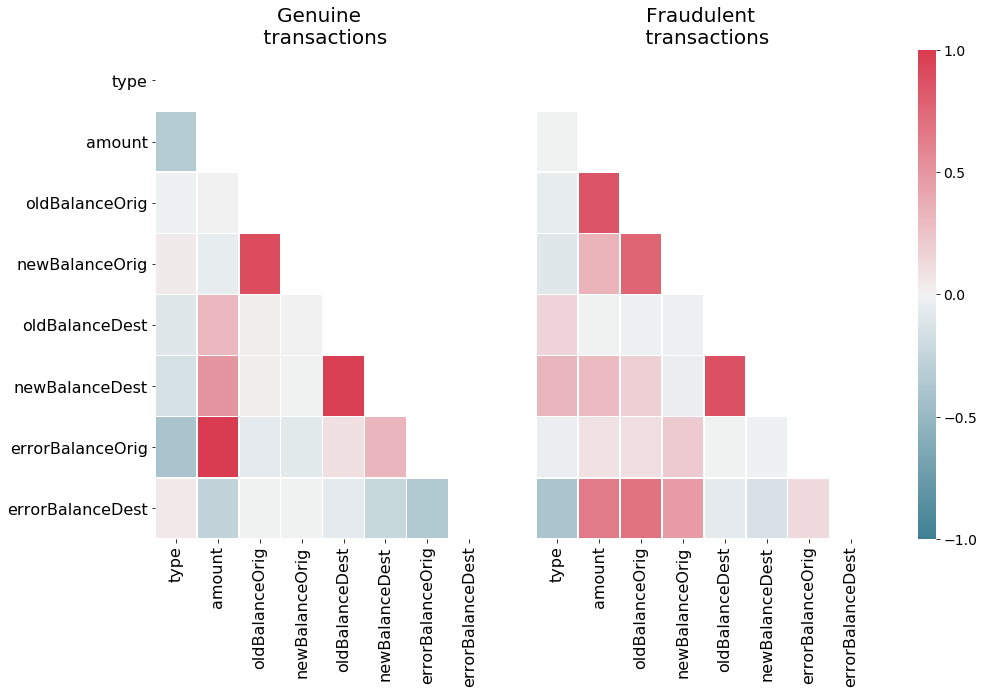

In [15]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## Machine Learning to Detect Fraud in Skewed Data
Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.

In [16]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


In [17]:
# Split the data into training and test sets in a 80:20 ratio
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [ ]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

### Important Features for the ML Model
The figure below shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

### Visualization of ML Model
The root node in the decision tree visualized below is indeed the feature errorBalanceOrig, as would be expected from its high significance to the model.

In [ ]:
to_graphviz(clf)

### Bias-Variance Tradeoff
The model we have learnt has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing min_child_weight and decreasing reg_lambda.

In [ ]:
# Long computation in this cell (~6 minutes)

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

In [ ]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

## Conclusion
We thoroughly interrogated the data at the outset to gain insight into which features could be discarded and those which could be valuably engineered. The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes. The method used in this kernel should therefore be broadly applicable to a range of such problems.